In [8]:
import matplotlib
import pandas
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster

In [5]:
## Exercise a)
df = pandas.read_csv("data/data_ehr.csv")

df_isna = df.isna()

na_ratio = df_isna.mean()

df_clean = df.loc[:, na_ratio <= 0.30]

print("number dimensions before cleaning:", df.shape[1])
print("number of dimensions after cleaning:", df_clean.shape[1])
print("number of instances (patients):", df.shape[0])

number dimensions before cleaning: 130
number of dimensions after cleaning: 97
number of instances (patients): 1384


In [ ]:
## Exercise b)

dtypes_df = df_clean.dtypes.to_frame("dtype").reset_index()
dtypes_df.columns = ["column", "dtype"]

fig, ax = plt.subplots(figsize=(1,0.1*len(dtypes_df)))
ax.axis("off")
table = ax.table(
    cellText=dtypes_df.values,
    colLabels=dtypes_df.columns,
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(dtypes_df.columns))))
plt.savefig("data/dtypes.png", bbox_inches="tight")

In [ ]:
## Exercise c)
from sklearn.metrics import silhouette_score

#filtering only numerical features
df_only_num = df_clean.select_dtypes(include=[np.number])

#impute NaN values and scale
imp = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='median')
scaler = sklearn.preprocessing.StandardScaler()
X_imputed = imp.fit_transform(df_only_num)
X_scaled = scaler.fit_transform(X_imputed)

#kmeans with different k's
sil_scores = []
for k in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_scaled)
    labels = kmeans.labels_
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append({"k": k, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best k for kmeans
best = sil_df.loc[sil_df["silhouette"].idxmax()]
print(f"Best k for kmeans: {int(best.k)}, silhouette: {best.silhouette:.3f}")

#Agglomerative Clustering with different k's
sil_scores = []
for k in range(2, 11):
    ag = sklearn.cluster.AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ag.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append({"k": k, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best k for Agglomerative Clustering
best = sil_df.loc[sil_df["silhouette"].idxmax()]
print(f"Best k for AG: {int(best.k)}, silhouette: {best.silhouette:.3f}")


#Affinity Propagation with different dampings
sil_scores = []
for damping in np.arange(0.5, 1.0, 0.1):
    ap = sklearn.cluster.AffinityPropagation(damping=damping, random_state=0)
    labels = ap.fit_predict(X_scaled)
    # Silhouette braucht >=2 Cluster
    if len(set(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
    else:
        sil = np.nan
    sil_scores.append({"damping": damping, "silhouette": sil})

sil_df = pandas.DataFrame(sil_scores)
print(sil_df)

# best damping for Affinity Propagation
if sil_df["silhouette"].notna().any():
    best = sil_df.loc[sil_df["silhouette"].idxmax()]
    print(f"Best damping for Affinity Propagation: {best.damping:.1f}, silhouette: {best.silhouette:.3f}")
else:
    print("No valid silhouette for Affinity Propagation")


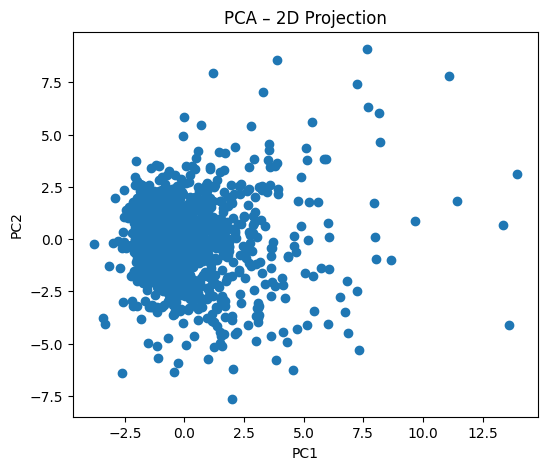

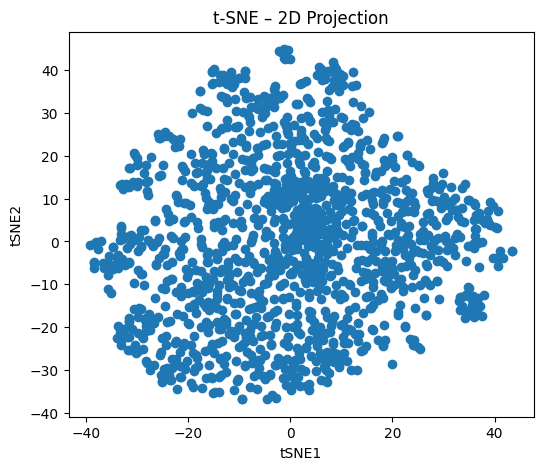

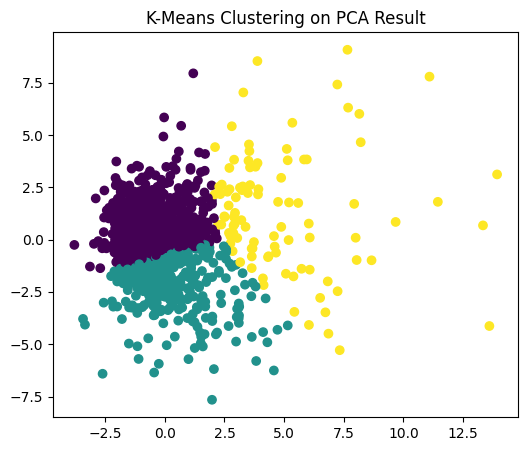

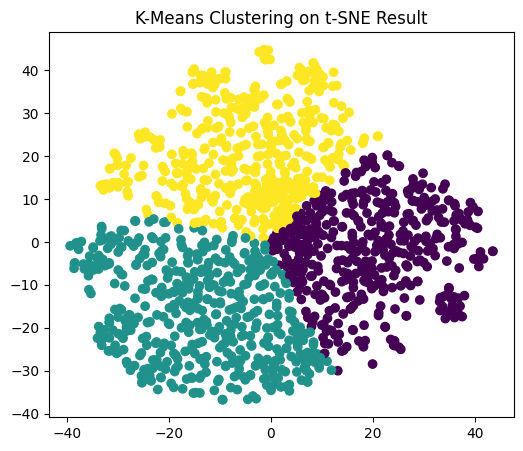

In [11]:
# Prepare numerical data
df_num = df_clean.select_dtypes(include=[np.number])
X = df_num.values

# Impute missing values (mean)
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA → 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA – 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# t-SNE → 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title("t-SNE – 2D Projection")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

# Clustering on PCA (K-Means k=3)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca)
plt.title("K-Means Clustering on PCA Result")
plt.show()

# Clustering on t-SNE (K-Means k=3)
kmeans_tsne = KMeans(n_clusters=3, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne)
plt.title("K-Means Clustering on t-SNE Result")
plt.show()